In [25]:
import pandas as pd
from scipy.stats import ttest_ind, ttest_ind_from_stats
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Independently Distributed
-------------------------------

The assumption that data is "IID" or independently and identically distributed is one of those assumptions underpinning common asymptotic statistical methods that doesn't always get checked. Unfortunately, this can lead to underestimate of variance and an over-optimistic estimates of treatment effects. 

In this post, I'll demonstrate how to detect bias due to IID unmet assumptions and two ways to correct it.

Throughout the post, I'll focus on a single predictor variable: randomly assigned treatment/control status. Our null hypothesis will be that the assignment has no effect (equivalent to a "flat" experiment).

**Sanity check: p-values under the null should be uniformly distributed**

Under the null hypothesis, the p-value is exactly equivalent to the false positive rate for rejecting $H_0$. Therefore, p-values should be uniformly distributed under $H_0$. We should see $5%$ of p-values should be less than 0.05, $10%$ under $0.10$ and so on.

The simple test below simulates an AA test, meaning we'll enforce $H_0$ by using the same hyperparameters for both treatment and control. We simulate 500 random experiments and plot the sorted p-values to see if they match our uniformness assumption.


In [2]:
unbiased_pvals = []
def unbiased(n=100):
    for i in range(n):
        t = np.random.poisson(list(np.random.gamma(4, 1, 500)))
        c = np.random.poisson(list(np.random.gamma(4, 1, 500)))
        unbiased_pvals.append(ttest_ind(t, c)[1])

In [3]:
unbiased_pvals = []
unbiased(500)

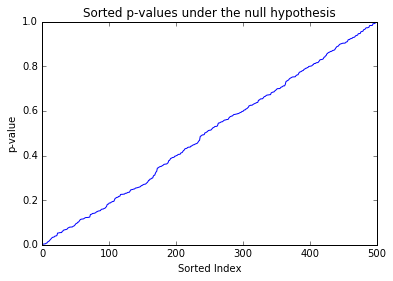

In [4]:
plot(sorted(unbiased_pvals))
xlabel("Sorted Index")
ylabel("p-value")
_ = title("Sorted p-values under the null hypothesis")

Yep! The plot shows very close to 50 p-values under $0.10$, 25 less than $0.05$ and so on.

In [5]:
print(sum([u < 0.05 for u in unbiased_pvals]) / len(unbiased_pvals))
print(sum([u < 0.1 for u in unbiased_pvals]) / len(unbiased_pvals))

0.046
0.106


**Breaking the independence assumption: grouping observations**
    
One common way that independence gets violated is when we observe an outcome multiple times from the same user. Examples where I've seen this happen in practice are:
* Page load times where some users visit the page multiple times.
* Observing individual users grouped within large companies, where there is often a "company effect" that explains some of the outcome.

We can simulate grouped observations by reusing the same hyperparameter multiple times. In the example below, we draw 500 observations for each grouping. However, we only use 100 unique hyperparameter values. 

In [6]:
biased_pvals = []
def biased(n=100):
    for i in range(n):
        t = np.random.poisson(list(np.random.gamma(4, 1, 100)) * 5)
        c = np.random.poisson(list(np.random.gamma(4, 1, 100)) * 5)
        biased_pvals.append(ttest_ind(t, c)[1])

In [7]:
biased_pvals = []
biased(500)

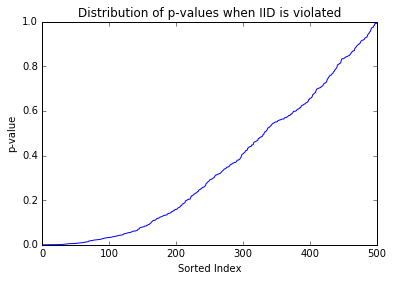

In [8]:
plot(sorted(biased_pvals))
xlabel("Sorted Index")
ylabel("p-value")
_ = title("Distribution of p-values when IID is violated")

Nearly $25%$ of our 500 experiments produce a p-value less than $0.05$, which means we are in danger of a false positive 5 times more often!

In [9]:
print(sum([u < 0.05 for u in biased_pvals]) / len(biased_pvals))
print(sum([u < 0.1 for u in biased_pvals]) / len(biased_pvals))

0.248
0.326


For comparison, here are the two plots side-by-side:

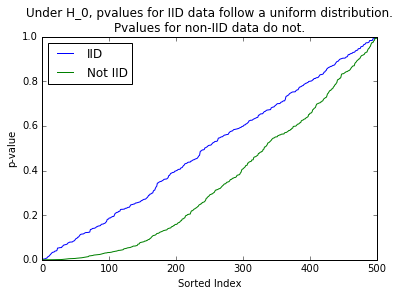

In [10]:
plot(sorted(unbiased_pvals))
plot(sorted(biased_pvals))
legend(["IID", "Not IID"], loc="upper left")
xlabel("Sorted Index")
ylabel("p-value")
_ = title("Under H_0, pvalues for IID data follow a uniform distribution.\nPvalues for non-IID data do not.")

Correcting IID issues: Permutation Test
-------------------------------

Permutation tests are the statistical jackhammer: while the may not be an efficient solution, they will often solve your problem. In this case, we'll use a permutation test to correctly estimate the variance of our samples. The idea in a permutation test is to simulate many experiments where $H_0$ applies on a population. The steps are: calculate a statistic of interest, repeatedly shuffle an independent variable, re-calculate the statistic of interest for each sample, and finally see where the originally observed data sits in the sorted order of statistics. The sort index is the p-value: if your metric of interest is in the $5%$ tails of the distribution of statistics then it is statistically significant at $p=0.05$.

There is one very easy mistake to make in a permutation test. Recall that we set our data up by observing 5 measurements from each of 100 hyperparameter values. Think of the 100 hyperparameters as 100 people who each get observed 5 times. Our permutation must permute *hyperparameters* not observations. Less formally, we can label our observational unit and our experimental unit. The observation unit is what we observe, but the experimental unit is the unit that we randomize in a controlled study (or the grouping parameter in observational data). In our contrived example, the experimental unit is a hyperparameter value and the observation unit is the final Poisson variable. In the real world, it's generally easy to identify both:
* For perf studies on the web, the Experimental unit is a user and the Observation unit is a single page load.
* For B2B companies, the Experimental unit might be a customer (a business) and the Observation unit is an employee of the customer (or a customer of the customer).

Below, we use a bit of tricky indexing to ensure that the experimental unit it shufled. I've also included an incorrect permutation on the observational unit.

In [122]:
def _bad_shuffle_stat(t, c):
    full_input = list(t) + list(c)
    num_t = len(t)
    test_stats = []
    for i in range(500):
        random.shuffle(full_input)
        test_stats.append(np.average(full_input[:num_t]) - np.average(full_input[num_t:]))
    return sorted(test_stats)


def _correct_shuffle_stat(t, c):
    # reshape input so that all observations per experimenal unit are on one row.
    num_t = int(len(t) / 5)
    full_input = np.concatenate([t.reshape(5, -1).T, c.reshape(5, -1).T])

    num_experimental_units = full_input.shape[0]
    test_stats = []
    
    for i in range(500):
        raw_indices = list(range(num_experimental_units))
        random.shuffle(raw_indices)
        randomized_input = full_input[raw_indices, :]  # reorder rows of num_experimental_units
        test_stat = np.average(randomized_input[:num_t,:]) - np.average(randomized_input[num_t:,:])
        test_stats.append(test_stat)
    return test_stats


def biased_permutation(n=100, use_correct=True):
    simulated_p_vals = []
    test_stats = []
    shuffle_fxn = _correct_shuffle_stat if use_correct else _bad_shuffle_stat
    for i in range(n):
        t = np.random.poisson(list(np.random.gamma(4, 1, 100)) * 5)
        c = np.random.poisson(list(np.random.gamma(4, 1, 100)) * 5)
        
        test_stat = np.average(t) - np.average(c)
        test_stats.append(test_stat)
        permutation_stats = shuffle_fxn(t, c)
        simulated_p_vals.append(sum([test_stat < p for p in permutation_stats]) / len(permutation_stats))
    return simulated_p_vals, test_stats

In [123]:
biased_permutation_test, _ = biased_permutation(500)

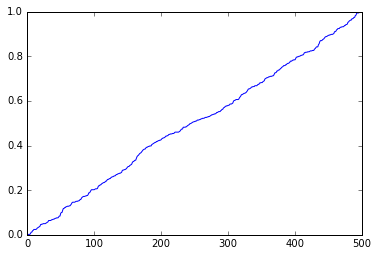

In [129]:
_ = plot(sorted(biased_permutation_test))

In [126]:
print(sum([u < 0.05 for u in biased_permutation_test]) / len(biased_permutation_test))
print(sum([u < 0.1 for u in biased_permutation_test]) / len(biased_permutation_test))

0.048
0.102


The next plot compares the correct (by user) permutation to an incorrect by-observation permutation.

In [127]:
biased_permutation_test_incorrect, _ = biased_permutation(500, use_correct=False)

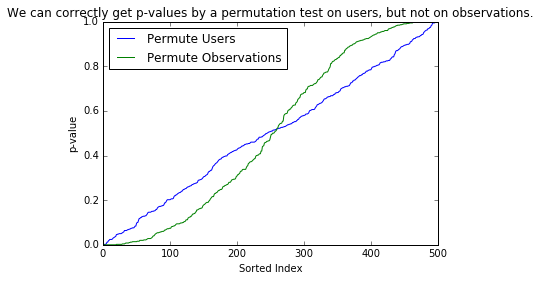

In [128]:
plot(sorted(biased_permutation_test))
plot(sorted(biased_permutation_test_incorrect))
legend(["Permute Users", "Permute Observations"], loc="upper left")
xlabel("Sorted Index")
ylabel("p-value")
_ = title("We can correctly get p-values by a permutation test on users, but not on observations.")

Correcting p-values faster: bootstrapping
-----------------------------------------

In [213]:
def bootstrap_variance_incorrect(sample):
    # incorrectly bootstrap on observations
    means = []
    for i in range(500):
        means.append(var(sample[random.choice(range(sample.shape[0]), sample.shape[0], replace=True)]))
    return np.average(means)

def bootstrap_variance(sample):
    # reshape so all entries for single user are on one row.
    sample = sample.reshape(5, -1).T
    means = []
    for i in range(500):
        means.append(var(sample[random.choice(range(sample.shape[0]), sample.shape[0], replace=True),:]))
    return np.average(means)

def biased_bootstrap(n=100, use_correct=True):
    bootstrap_fxn = bootstrap_variance if use_correct else bootstrap_variance_incorrect
    
    p_values = []
    
    for i in range(n):
        t = np.random.poisson(list(np.random.gamma(4, 1, 100)) * 5)
        c = np.random.poisson(list(np.random.gamma(4, 1, 100)) * 5)
       
        t_mean = np.average(t)
        c_mean = np.average(c)
        t_var = bootstrap_fxn(t)
        c_var = bootstrap_fxn(c)
        p_values.append(ttest_ind_from_stats(t_mean, t_var ** .5, 500, c_mean, c_var ** .5, 500)[1])
    return p_values

In [214]:
biased_bootstrap_pvals = biased_bootstrap(100, True)

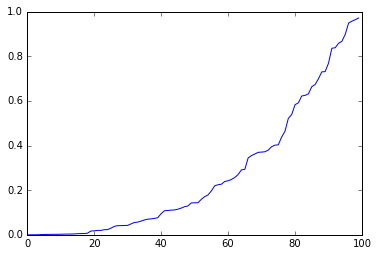

In [215]:
_ = plot(sorted(biased_bootstrap_pvals))

In [216]:
bootstrap_variance(t)

9.0511844559999997

In [217]:
var(t)

9.0690240000000006

In [218]:
bootstrap_variance_incorrect(t)

9.0060263760000012